<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a><center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em>

# Decision Trees und Random Forests Projekt - Lösungen

Für dieses Projekt werden wir öffentlich verfügbare Daten von [LendingClub.com](https://de.wikipedia.org/wiki/Lending_Club) verwenden. Lending Club bringt Leute zusammen, die Geld brauchen (Leihende) und solche, die Geld investieren möchten (Geldgeber). Als Invester möchte man dann verständlicherweise vor allem an die Leute sein Geld verleihen, die es mit einer hohen Wahrscheinlichkeit zurückzahlen. Wir werden versuchen ein Modell zu erstellen, dass bei dieser Vorhersage hilft.

Wir werden Daten von 2007 bis 2010 verwenden, bevor das Unternehmen an die Börse ging. Anhand der Daten werden wir versuchen vorherzusagen, ob ein Leihender das Geld zurückgezahlt hat oder nicht. Die Daten haben wir als CSV in den Kursunterlagen beigefügt. Diese Datei wurde bereits um die nicht verfügbaren Einträge gesäubert.

Schauen wir uns noch die verfügbaren Spalten an:

* credit.policy: 1 falls der Kunde die Risikobewertung besteht, 0 falls nicht.
* purpose: Der Zweck des Kreidts (Werte sind "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", und "all_other").
* int.rate: Der Zinssatz des Kreidts als Anteil (eine Rate von 11% würde 0.11 sein). Kreditnehmer, die LendingClub.com als riskanter einstuft erhalten einen höheren Zins.
* installment: Die monatliche Zeilzahlung, die der Kreditnehmer leistet, wenn der Kredit finaziert wird.
* log.annual.inc: Der natürliche Log des angegebenen jährlichen Einkommens des Kreditnehmers.
* dti: Die "debt-to-income" Rate des Kreditnehmers (Kredit geteilt durch jährliches Einkommen.
* fico: Der FICO Kreditscore des Kreditnehmers.
* days.with.cr.line: Anzahl der Tage an denen der Kunde einen Dispokredit hatte.
* revol.bal: Die Bilanz am Ende eines Kreditkartenabrechnungszeitraums.
* revol.util: Der erstattete Anteil am Gesamtkredit.
* inq.last.6mths: Die Anzahl an Anfragen, die Kreditgeber in den letzten 6 Monaten an den Kreditnehmer gestellt haben.
* delinq.2yrs: Die Anzahl der Vorkommnisse eines Verzugs von über 30 Tagen innerhalb der letzten 2 Jahre.
* pub.rec:  Die Anzahl an negativen Einträgen (Bankrott, Steuerverzug, Verurteilungen,...) des Kreditnehmers.

## Libraries importieren

**Importiere die üblichen Libraries für Pandas und zur Visualisierung. Sklearn können wir später noch importieren.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## My_logger und My_timer Funktionen hinzufügen

In [3]:
# Decorators
from functools import wraps


def my_logger(orig_func):
    import logging
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper


def my_timer(orig_func):
    import time

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

## Die Daten laden

**Nutze Pandas, um die Datei "loan_data.csv" als DataFrame namens "loans" zu laden.**

In [4]:
loans = pd.read_csv('loan_data.csv')

**Schau dir die info(), head() und describe() Methoden für loans an.**

In [5]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [6]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [7]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## Explorative Daten Analyse

Visualisieren wir nun einige Daten! Wie nutzen dazu Seaborn und Pandas eingebaute VIsualisierungsfähigkeiten. Wer möchte kann aber auch andere Methoden verwenden. Die Farben müssen z.B. nicht genau übereinstimmen. Es geht hier darum ein Verständnis für die Daten zu entwickeln!

**Erstelle ein Histogram zweier FICO Verteilungen übereinandern, je eins nach dem credit.policy Ergebnis.**

*Hinweis: Das ist bereits etwas knifflig. Keine Sorge, die Lösung hilft im Zweifelsfall weiter! Meine Empfehlung ist die Verwendung von Pandas .hist() Funktion.*

Text(0.5, 0, 'FICO')

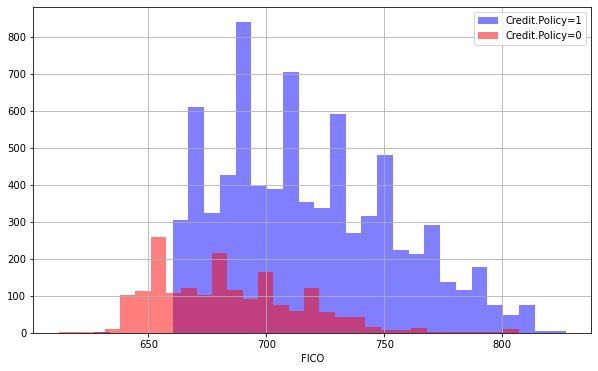

In [8]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')
loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

**Erstelle ein gleiches Diagramm, dass diesesmal nach der "not.fully.paid" Spalte trennt.**

Text(0.5, 0, 'FICO')

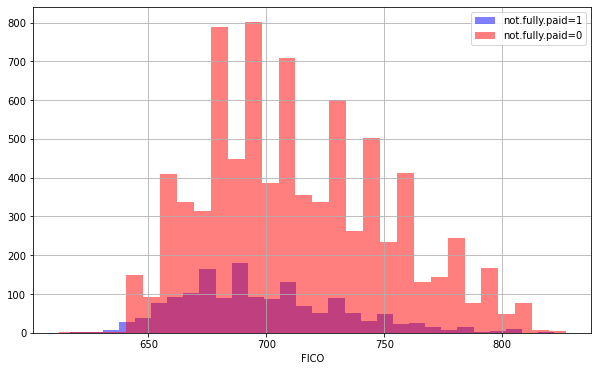

In [9]:
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not.fully.paid=1')
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='not.fully.paid=0')
plt.legend()
plt.xlabel('FICO')

**Erstelle ein Countplot unter Verwendung von Seaborn, das die Anzahl der Leihgaben (en. loans) nach Zweck (en. purpose) anzeigt. Der Hue soll dabei durch die Spalte "not.fully.paid" definiert sein.**

<AxesSubplot:xlabel='purpose', ylabel='count'>

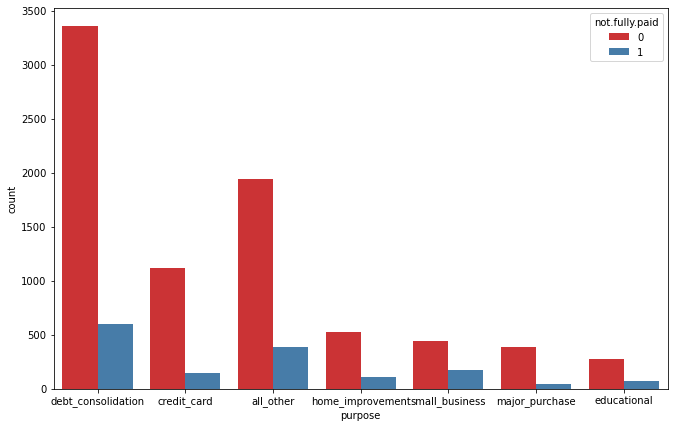

In [10]:
plt.figure(figsize=(11,7))
sns.countplot(x='purpose',hue='not.fully.paid',data=loans,palette='Set1')

**Lasst uns den Trend zwischen FICO Score und den Zinsen (en. interest rate) betrachten. Stelle dazu das folgende Jointplot nach.**

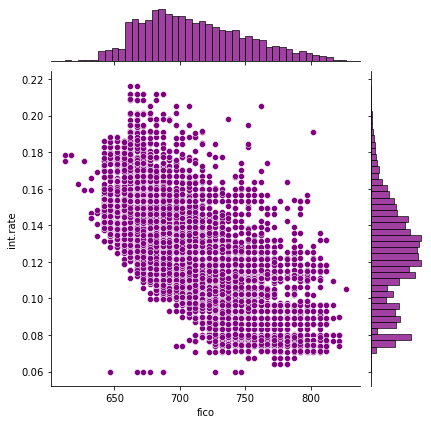

In [11]:
sns.jointplot(x='fico',y='int.rate',data=loans,color='purple')

**Erstelle die folgenden lmplots, um zu sehen, ob sich der Trend zwischen "not.fully.paid" und "credit.policy" unterscheidet. Schau in die Dokumentation von lmplot, wenn du nicht mehr weißt, wie man in zwei Spalten aufteilt.**

<Figure size 792x504 with 0 Axes>

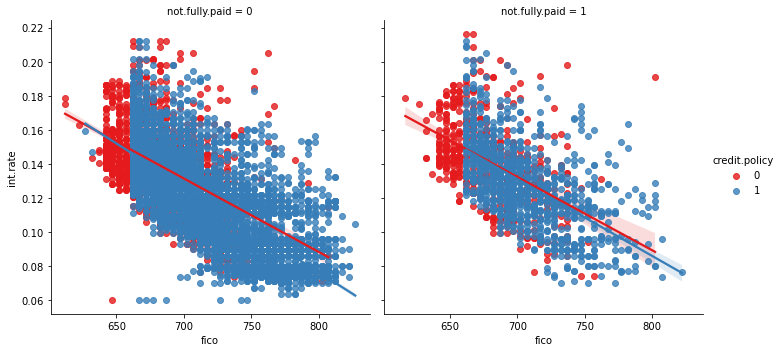

In [12]:
plt.figure(figsize=(11,7))
sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',
           col='not.fully.paid',palette='Set1')

## Die Daten vorbereiten

Bereiten wir unsere Daten nun für ein Random Forest Klassifikationsmodell vor!

**Schaue dir erneut loans.info() an.**

In [13]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


### Kategorische Eigenschaften

Achte darauf, dass die Spalte "purpose" (dt. Zweck) kategorisch ist. Das bedeutet wir müssen sie in Dummy-Variablen umwandeln, damit sklearn mit ihnen arbeiten kann. Für diesen Schritt verwenden wir `pd.get_dummies`.

Dieses Vorgehen kann auf weitere kategorische Inhalte angewendet werden, wenn es nötig sein sollte.

**Erstelle eine Liste, die nur ein Element enthält. Dieses Element soll der String "purpose" sein. Nenne diese Liste cat_feats.**

In [14]:
cat_feats = ['purpose']

**Nutze jetzt pd.get_dummies(loans,columns=cat_feats,drop_first=True), um einen korrigierten und größeren DataFrame zu erstellen. Nenne diesen DataFrame final_data.**

*Hinweis: Um mehrere kategorische Eigenschaften in Dummy-Variablen zu übertragen füge die entsprechenden Spalten einfach der Liste aus dem vorherigen Arbeitsschritt hinzu. Für unseren Datensatz hier müssen wir allerdings keine weitere Spalte berücksichtigen.*

In [15]:
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)

In [16]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit.policy               9578 non-null   int64  
 1   int.rate                    9578 non-null   float64
 2   installment                 9578 non-null   float64
 3   log.annual.inc              9578 non-null   float64
 4   dti                         9578 non-null   float64
 5   fico                        9578 non-null   int64  
 6   days.with.cr.line           9578 non-null   float64
 7   revol.bal                   9578 non-null   int64  
 8   revol.util                  9578 non-null   float64
 9   inq.last.6mths              9578 non-null   int64  
 10  delinq.2yrs                 9578 non-null   int64  
 11  pub.rec                     9578 non-null   int64  
 12  not.fully.paid              9578 non-null   int64  
 13  purpose_credit_card         9578 

## Train Test Split

Jetzt ist es an der Zeit unsere Daten aufzuteilen. 

**Nutze sklearn um unsere Daten in Trainings- und Testset aufzuteilen. Diesen Vorgang kennst du schon aus vorherigen Abschnitten.**

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Ein Entscheidungsbaummodell trainieren

Beginnen wir damit einen einfachen Entscheidungsbaum zu trainieren!

**Importiere den DecisionTreeClassifier**

In [19]:
from sklearn.tree import DecisionTreeClassifier

**Erstelle eine Instanz des DecisionTreeClassifier() namens dtree und fitte die Trainingsdaten darauf.**

In [20]:
dtree = DecisionTreeClassifier()

In [21]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

## Funktionstraining laut Aufgabe2


In [22]:
@my_logger
@my_timer
def modelruntime(): 
    return dtree.fit(X_train,y_train)
modelruntime()

modelruntime ran in: 0.05208897590637207 sec


DecisionTreeClassifier()

## Vorhersage und Auswertung

**Erstelle die Vorhersagen (en. predictions) aus den Testdaten und werte dann Classification Report und Confusion Matrix aus.**

In [23]:
predictions = dtree.predict(X_test)

## Funktionspredict laut Aufgabe 2

In [24]:
@my_logger
@my_timer
def dt_predict():
    return dtree.predict(X_test)
predict = dt_predict()

dt_predict ran in: 0.0020012855529785156 sec


In [25]:
from sklearn.metrics import classification_report,confusion_matrix

In [26]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2431
           1       0.18      0.22      0.20       443

    accuracy                           0.73      2874
   macro avg       0.52      0.52      0.52      2874
weighted avg       0.75      0.73      0.74      2874



In [27]:
print(confusion_matrix(y_test,predictions))

[[1992  439]
 [ 344   99]]


## Ein Random Forest Modell trainieren

Jetzt trainieren wir ein ganzes Modell!

**Erstelle eine Instanz des RandomForestClassifier und fitte die Trainignsdaten aus unserem vorherigen Schritt darauf.**

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rfc = RandomForestClassifier(n_estimators=600)

In [30]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

## Vorhersage und Auswertung

Jetzt können wir für y_test Werte vorhersagen und das Ergebnis auswerten.

**Sage die Klasse von not.fully.paid für die X_test Daten vorher.**

In [31]:
predictions = rfc.predict(X_test)

**Erstelle jetzt einen Classification Report aus den Ergebnissen. Erhälst du etwas komisches oder eine Art Warnung?**

In [32]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.55      0.02      0.05       443

    accuracy                           0.85      2874
   macro avg       0.70      0.51      0.48      2874
weighted avg       0.80      0.85      0.78      2874



In [44]:
accuracy_score(y_test,predictions)

0.8465553235908142

**Zeige jetzt noch die Confusion Matrix der Vorhersagen an.**

In [35]:
print(confusion_matrix(y_test,predictions))

[[2422    9]
 [ 432   11]]


**Welche Methode hat besser performt?**

In [36]:
# Kommt darauf an welche Metrik wir optimieren
# Achte auf den Recall beider Modelle
# Keiner war besonders gut 
# -> Wir müssen die Eigenschaften besser anpassen

# Gut gemacht!

## Testfälle


In [48]:
import unittest
import time
import warnings

class TestInput(unittest.TestCase):
  
    @classmethod
    def setUpClass(cls):
        # print('setupClass')   
        pass

    @classmethod
    def tearDownClass(cls): 
        # print('teardownClass')
        pass
    
    def setUp(self):
        print('setUp') 
        X = final_data.drop('not.fully.paid',axis=1)
        y = final_data['not.fully.paid']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
       
       
        dtree_test = DecisionTreeClassifier()
        
        time_1=time.time()
        dtree_test.fit(X_train,y_train)
        self.time_2 = time.time() - time_1
        
        predict= dtree.predict(X_test)
        classification_report(y_test,predict)
        self.actual_confusion_matrix = confusion_matrix(y_test,predictions)
        with open("testfile_1.txt", 'r') as f:
            Inhalt = f.read()
        
        self.testdata_score = float(Inhalt)
        self.actual_score = accuracy_score(y_test,predictions)
        self.representative_runtime= 0.05308842658996582
        
         # 1.Unittest, ob die Genauigkeit des Vorhersagewert korrekt funktioniert
    def test_fit(self):
        self.assertTrue(self.actual_score > self.testdata_score )
        print('- Aktueller Score der Vorhersage:',self.actual_score)
        print('- Testdaten Score:',self.testdata_score)
        
    # 2. Unittest, ob die Laufzeit der Trainingsfunktion, der Testklasse den Grenzwert von 120% nicht überschreitet  
    def test_train_execution_time(self):
        self.assertTrue(self.time_2 < self.representative_runtime * 1.2)
        print('- Laufzeit der Trainingsfunktion fit()',self.time_2) 
        print('- Grenzwert 120% der representativen Laufzeit:',self.representative_runtime * 1.2)
        
#run tests 
unittest.main(argv=['first-arg-is-ignored'], exit=False)
   

..

setUp
- Aktueller Score der Vorhersage: 0.8465553235908142
- Testdaten Score: 0.75
setUp
- Laufzeit der Trainingsfunktion fit() 0.06044793128967285
- Grenzwert 120% der representativen Laufzeit: 0.06370611190795898



----------------------------------------------------------------------
Ran 2 tests in 0.143s

OK
